# Food and Agricultural Trends

**Team Papillon**

Nowadays, environmental problems are becoming more and more serious and urgent to deal with. We cannot deny the impact of food and agriculture in general, on the environment. If we consider what we eat and how we grow it, we would find extensive damage to the environment (green gas emissions, soil depletion etc.) and also the wildlife (due to pesticides, fertilizers etc.). We are looking to use the data provided by FAOSTAT giving access to over 3 million time-series and cross sectional data relating to food and agriculture all over the world and try to generate insights and stories on the evolution of different socio-environmental factors such as the correlation between greenhouse gas emissions and agricultural growth for example. Through this work, we hope to gain a deeper insight on the evolution and the environmental impact of agriculture and food.

## Question 1 and 2

### Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
### Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import StandardScaler

## Importing the data

In order to find a model that helps in the understanding of the role of the variety of crops in the ecological influence of the agriculture, we need 3 datasets:

- The land usage
- The crops cultures
- The emissions related to the agriculture


In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")

dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")

dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")

## Cleaning

- Removing NAN
- Removing useless columns

In [3]:
dataLands = dataLands.dropna(subset=["element"])

dataCrops = dataCrops.dropna(subset=["element"])

dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})

Here is a graph that shows the progression of land usage within each continent.

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


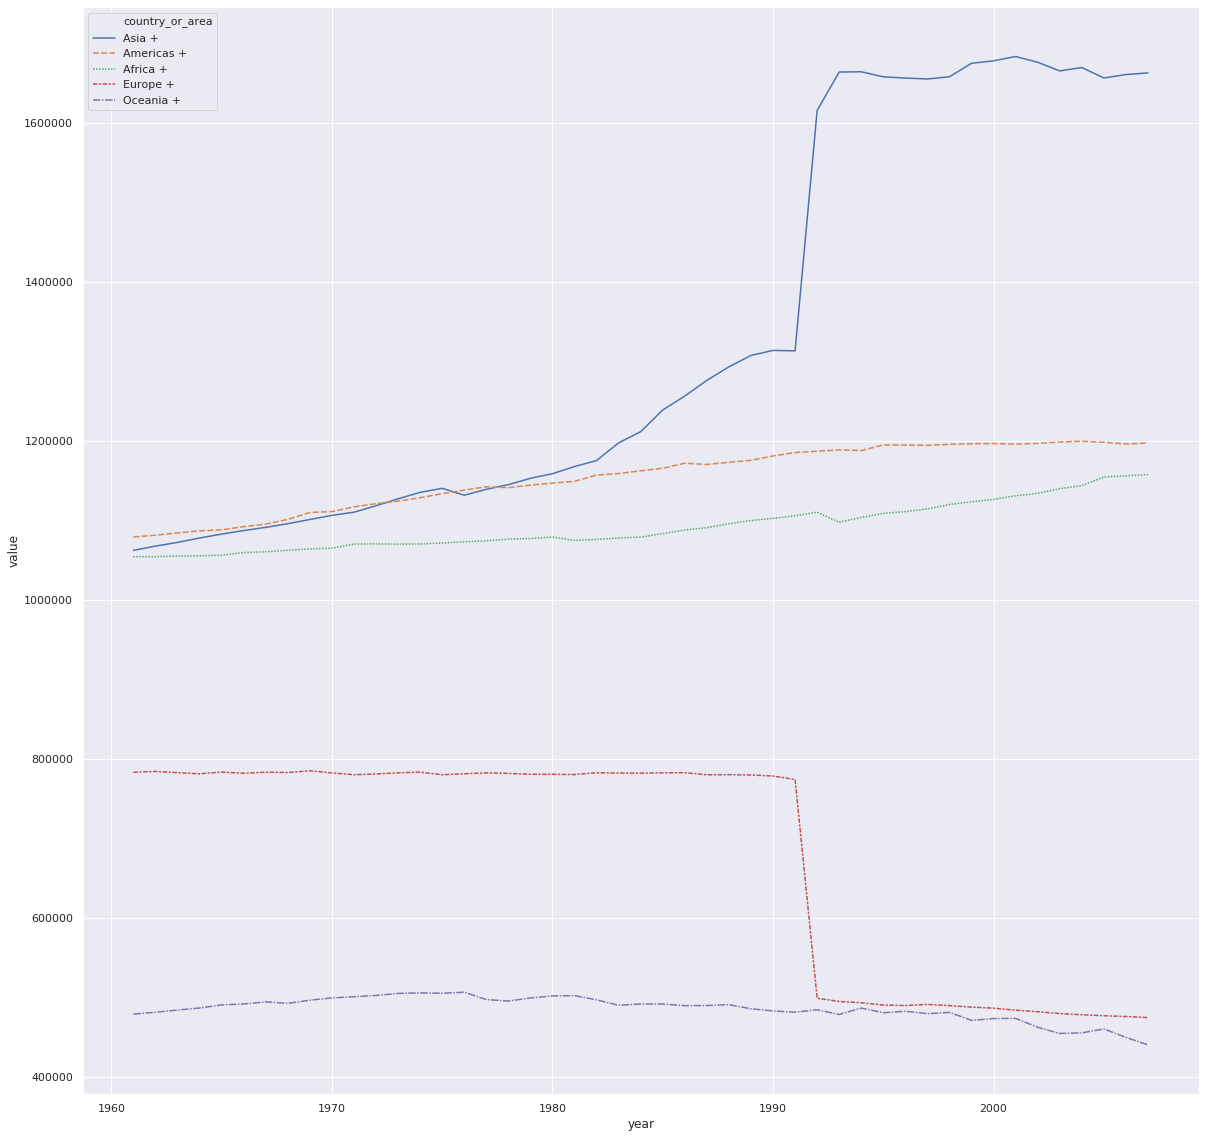

In [4]:
def cond_countries(dataLands):
    countries = ["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]
    truthTable = (dataLands["country_or_area"] == countries[0])
    for c in countries:
        truthTable = (dataLands["country_or_area"] == c) | truthTable
    return truthTable

dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
                                .where(cond_countries(dataLands))\
                                .dropna(subset=["country_or_area"])\
                                .sort_values("value",ascending=False)

sns.set(style="darkgrid")

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=dataLandsContinent, hue="country_or_area", ax=axes)

fg.show()

Here are the emissions of the BRICS throughout the years. We can see a clear progression (except for South Africa).

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


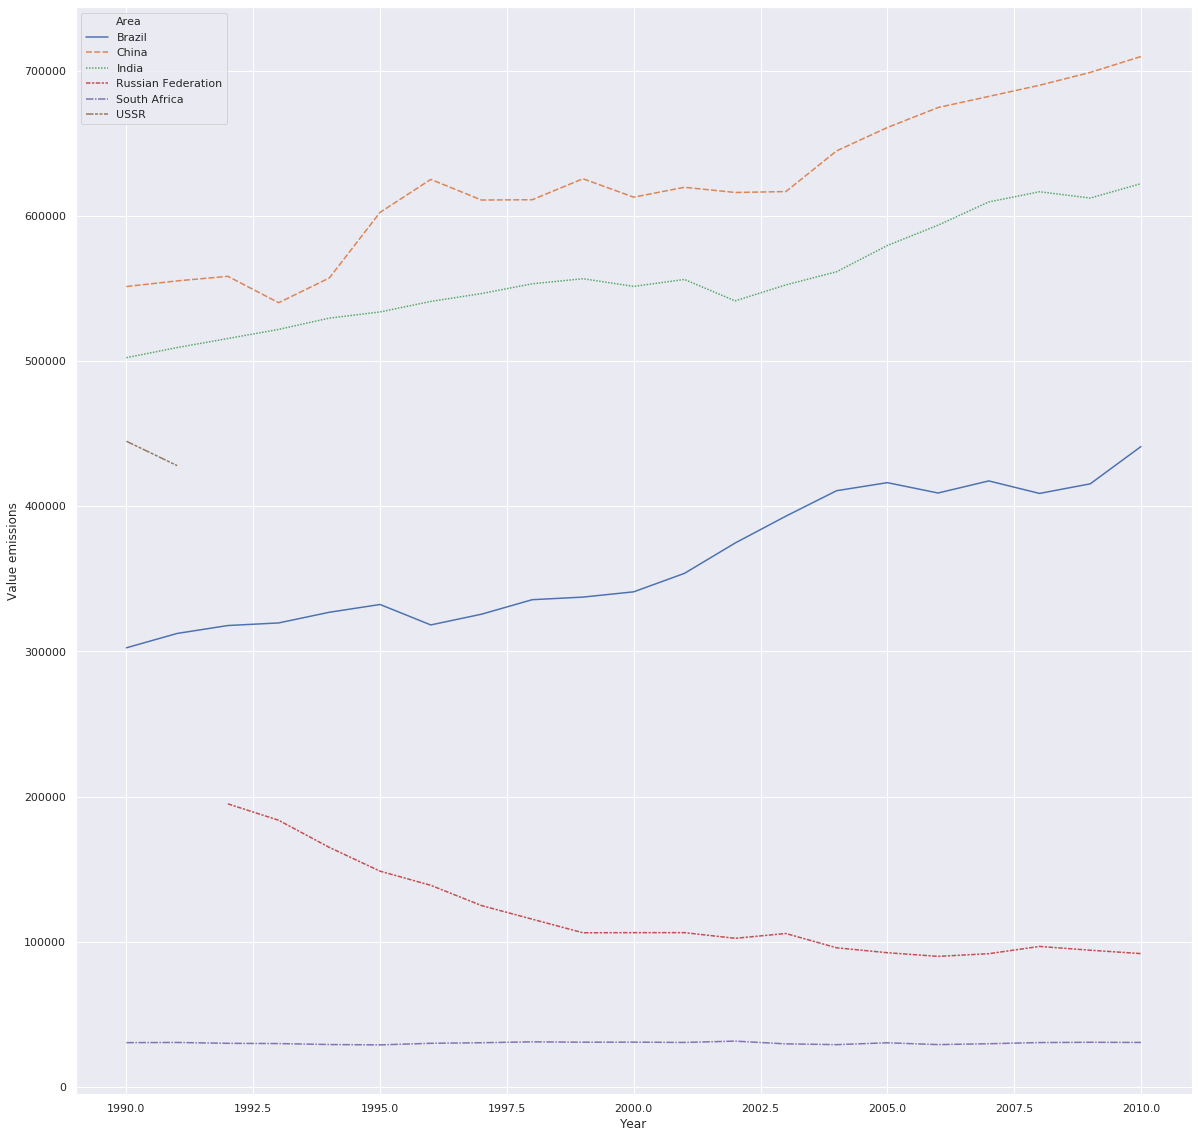

In [5]:
sns.set(style="darkgrid")

dataEmissionsAgrContinent = dataEmissionsAgriculture.where(dataEmissionsAgriculture["Area"].isin(["South Africa","Brazil", "China", "India", "USSR","Russian Federation"])).dropna()

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Value emissions", style="Area", data=dataEmissionsAgrContinent, hue="Area", ax=axes)

fg.show()

## Creating the dataset for processing

The dataset we create for processing consist in the aggregation of the area harvested of for each crop, by year and by country, and the emissions of greenhouse gases by year and by country as well. The goal will be to find a model that explain and helps in predicting the emissions, based on the other features (country, year and crops).

In [6]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions = crops.pivot_table(values='Value area',index=["Area","Year"],columns="category").reset_index()
cropsAndEmissions = cropsAndEmissions.fillna(0)
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])
cropsAndEmissions

,Area,Year,agave_fibres_nes,almonds_with_shell,anise_badian_fennel_corian,apples,apricots,arecanuts,artichokes,asparagus,...,vegetables_melons_total,vetches,walnuts_with_shell,watermelons,wheat,yams,yautia_cocoyam,Area Code,Unit emissions,Value emissions
29,Afghanistan,1990.0,0.0,5400.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,54600.0,0.0,2300.0,8200.0,1570000.0,0.0,0.0,2.0,Gigagrams,7342.7099
30,Afghanistan,1991.0,0.0,5500.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,52500.0,0.0,2300.0,7800.0,1690000.0,0.0,0.0,2.0,Gigagrams,7631.0272
31,Afghanistan,1992.0,0.0,5500.0,700.0,2340.0,5060.0,0.0,0.0,0.0,...,52900.0,0.0,2300.0,7800.0,1600000.0,0.0,0.0,2.0,Gigagrams,7631.4427
32,Afghanistan,1993.0,0.0,5500.0,700.0,2300.0,5100.0,0.0,0.0,0.0,...,54900.0,0.0,2300.0,7800.0,1900000.0,0.0,0.0,2.0,Gigagrams,7702.7416
33,Afghanistan,1994.0,0.0,5500.0,700.0,2350.0,5100.0,0.0,0.0,0.0,...,56900.0,0.0,2300.0,7800.0,2000000.0,0.0,0.0,2.0,Gigagrams,7699.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,Zimbabwe,2003.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,25937.0,0.0,0.0,0.0,26500.0,0.0,0.0,181.0,Gigagrams,9779.6837
10728,Zimbabwe,2004.0,0.0,0.0,200.0,750.0,20.0,0.0,17.0,60.0,...,26092.0,0.0,0.0,0.0,26300.0,0.0,0.0,181.0,Gigagrams,10470.7635
10729,Zimbabwe,2005.0,0.0,0.0,200.0,900.0,20.0,0.0,17.0,60.0,...,26242.0,0.0,0.0,0.0,28000.0,0.0,0.0,181.0,Gigagrams,9877.5998
10730,Zimbabwe,2006.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,23502.0,0.0,0.0,0.0,35000.0,0.0,0.0,181.0,Gigagrams,10053.3116


## Learning to predict emissions

Here, we try to create a model by doing a logistic regression on the data. We first try to optimize the alpha parameter on a predefined interval and then we use it to train the model.

Best alpha is 29.032258064516128 with a MSE of 392737681.660032 .


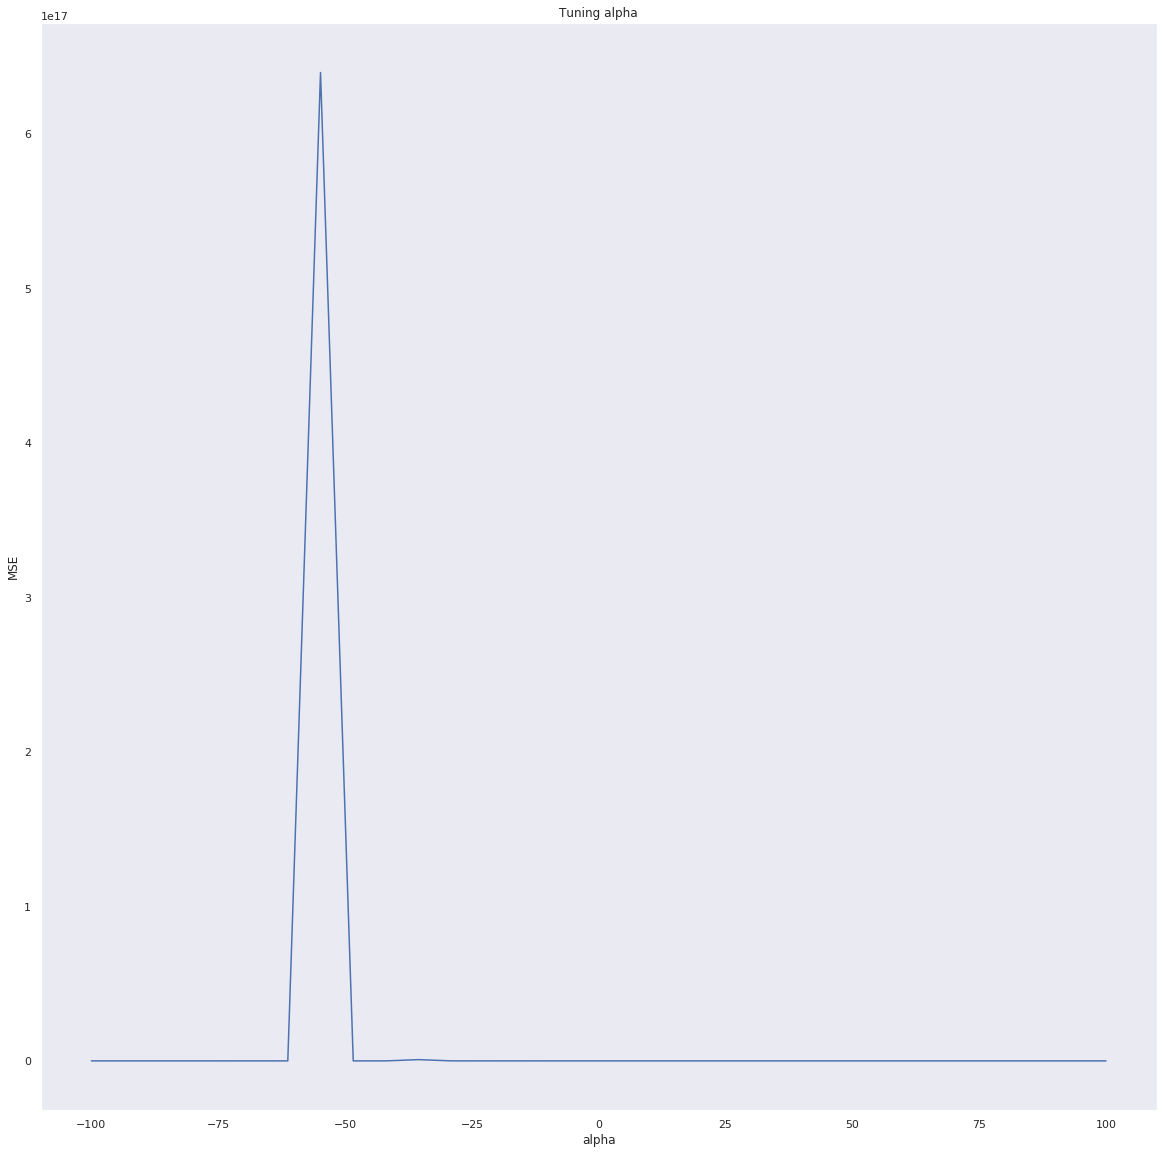

In [7]:
SEED = 1
st_pipeline = Pipeline([('scl', StandardScaler()), ('ridge', Ridge(copy_X=True, random_state=SEED))])
st_pipeline

#features = ["Area","category"]

XRidge2 = pd.get_dummies(cropsAndEmissions.drop(["Area Code","Unit emissions", "Value emissions"], axis=1))
yRidge2 = cropsAndEmissions["Value emissions"]

results = []

# Tune for alpha using 10 fold crossvalidation when calculating the mean squared error.
for alpha in np.linspace(-100, 100, 32):
    st_pipeline.set_params(ridge__alpha= alpha) 
    neg_MSE = cross_val_score(st_pipeline, XRidge2, yRidge2, scoring='neg_mean_squared_error', cv=10)  # we use 10 folds crossvalidation since 10 
                                                                                                      # is pretty much standard in the industry
    results.append([neg_MSE, alpha])
    
# Take the mean MSE for each level of alpha
for i in range(len(results)):
    results[i][0] = -np.mean(results[i][0])
    
# Plot the results
plt.figure(figsize=(20,20))
plt.plot([row[1] for row in results], [row[0] for row in results])
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Tuning alpha');
plt.grid()

best_st_alpha = min(results)[1]
print('Best alpha is', best_st_alpha, 'with a MSE of', min(results)[0],'.')

In [8]:
st_Model = st_pipeline.set_params(ridge__alpha= best_st_alpha)  # use best alpha calculated above
st_Model.fit(XRidge2, yRidge2)                                  # fit the new model

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=29.032258064516128, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=1, solver='auto', tol=0.001))],
         verbose=False)

In [9]:
#st_Model.named_steps["ridge"].coef_
weights = pd.DataFrame([XRidge2.columns,st_Model.named_steps["ridge"].coef_]).transpose().sort_values(1)
weights

,0,1
91,mushrooms_and_truffles,-2158.66
107,other_melons_inc_cantaloupes,-2080.23
356,Area_Ukraine,-1600.37
301,Area_Nigeria,-1505.16
216,Area_Cuba,-1482.57
...,...,...
195,Area_Brazil,3906.77
143,soybeans,3947.84
83,maize,4543.2
179,Area_Australia,6052.34


Further analysis will be conducted in order to create efficient predictions. This first analysis already gave us clear insight of the data and helps us in assessing the feasability of this research.

## Plan

The next steps will be :

- Visualize the output of the model and its relation to reality.
- Try new models and assess their performances.
- Make predictions on the future using these regressions.
- Extract guidelines that could help in reducing emissions in the future, based on these data.
- Criticize these guidelines and the predictions using more domain-related knowledge.

## Output of the model

In [10]:
weights.columns = ["name", "weight"]

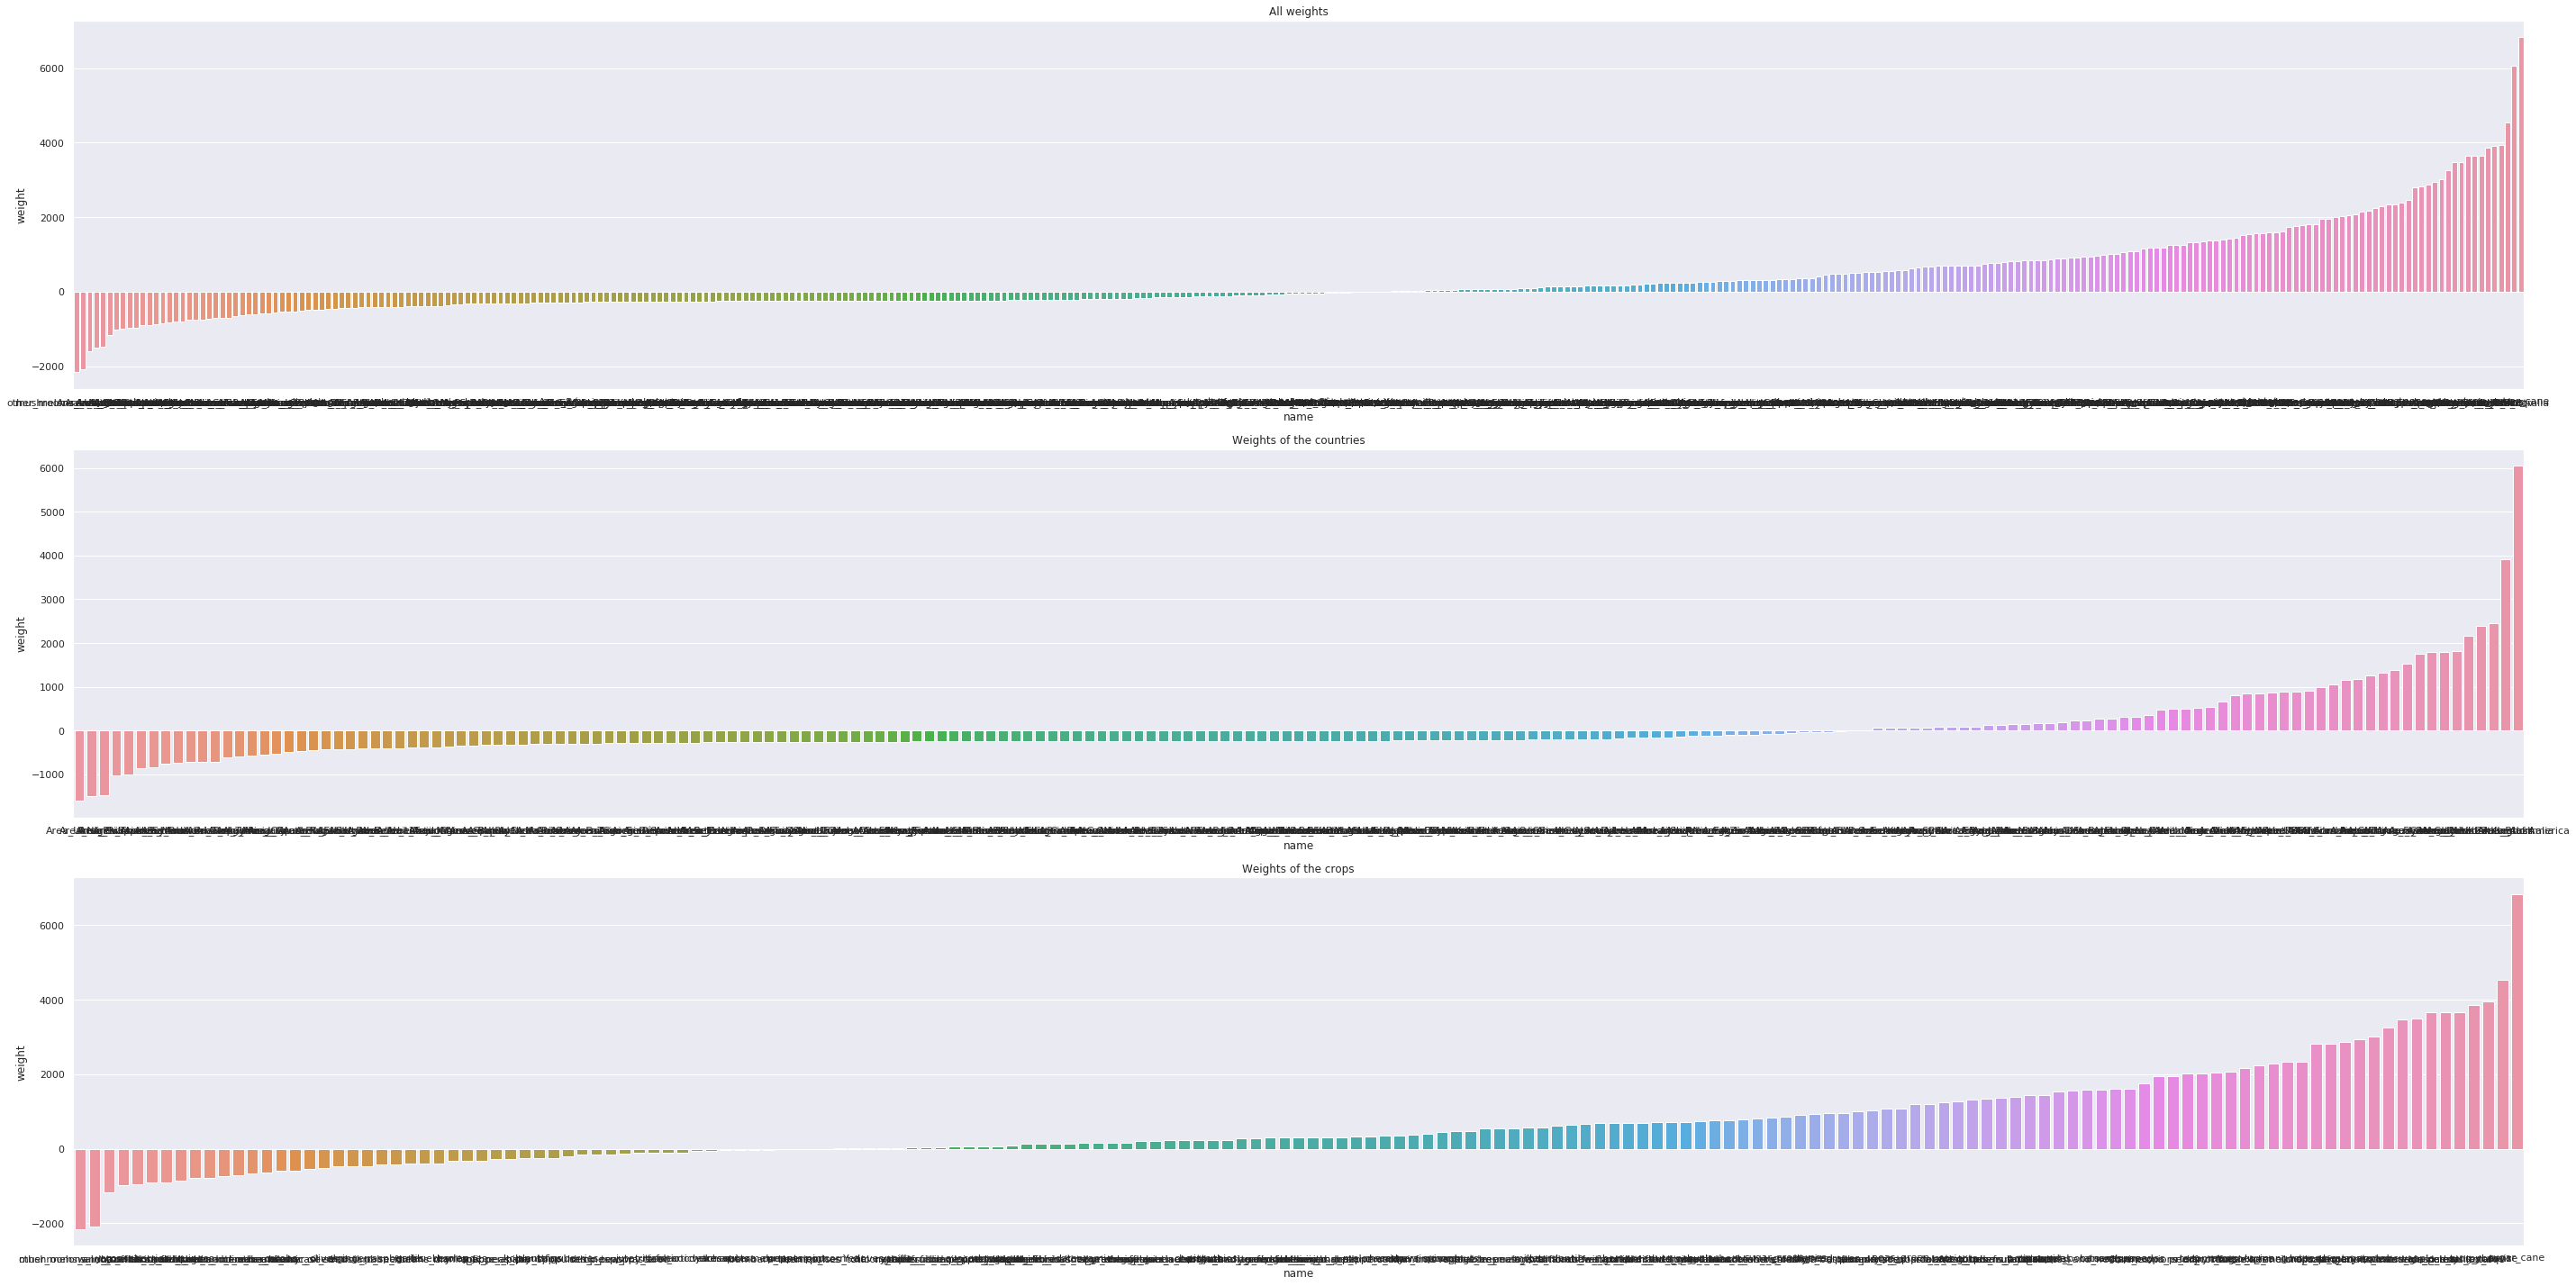

In [11]:
fg = plt.figure(figsize=(40,20))

axes1 = fg.add_subplot(3,1,1)
sns.barplot(x="name", y="weight", data=weights, ax=axes1)
axes1.set_title("All weights")

axes2 = fg.add_subplot(3,1,2)
sns.barplot(x="name", y="weight", data=weights.where(weights.name.str.contains("Area")).dropna(), ax=axes2)
axes2.set_title("Weights of the countries")

axes3 = fg.add_subplot(3,1,3)
sns.barplot(x="name", y="weight", data=weights.mask(weights.name.str.contains("Area")).dropna(), ax=axes3)
axes3.set_title("Weights of the crops")

fg.tight_layout()

In [12]:
weights.where(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight")#.where("weight > 0")

,name,weight
339,Area_Sweden,13.2048
325,Area_Senegal,63.8552
266,Area_Kenya,67.8984
303,Area_Norway,69.4197
180,Area_Austria,71.6935
309,Area_Peru,75.0356
334,Area_South Africa,76.5428
340,Area_Switzerland,76.5858
226,Area_Egypt,88.2928
187,Area_Belgium,89.551


In [13]:
weights.mask(weights.name.str.contains("Area")).where(weights.weight > 0).dropna().sort_values("weight")#.where("weight > 0")

,name,weight
125,pulses_total,5.18685
0,Year,9.79324
41,cloves,11.7426
35,chicory_roots,14.0448
162,vanilla,22.7541
...,...,...
31,cereals_total,3658.05
161,tung_nuts,3867.19
143,soybeans,3947.84
83,maize,4543.2


In [14]:
crops = dataCrops.drop(["element_code"], axis=1)\
                .where(dataCrops["element"] == "Area Harvested")\
                .dropna(subset=["element"])\
                .drop(["element", "value_footnotes"],axis=1)\
                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
crops.category.unique()

array(['agave_fibres_nes', 'almonds_with_shell',
       'anise_badian_fennel_corian', 'apples', 'apricots', 'arecanuts',
       'artichokes', 'asparagus', 'avocados', 'bambara_beans', 'bananas',
       'barley', 'beans_dry', 'beans_green', 'berries_nes', 'blueberries',
       'brazil_nuts_with_shell', 'broad_beans_horse_beans_dry',
       'buckwheat', 'cabbages_and_other_brassicas', 'canary_seed',
       'carobs', 'carrots_and_turnips', 'cashew_nuts_with_shell',
       'cashewapple', 'cassava', 'castor_oil_seed',
       'cauliflowers_and_broccoli', 'cereals_nes',
       'cereals_rice_milled_eqv', 'cereals_total', 'cherries',
       'chestnuts', 'chick_peas', 'chicory_roots',
       'chillies_and_peppers_dry', 'chillies_and_peppers_green',
       'cinnamon_canella', 'citrus_fruit_nes', 'citrus_fruit_total',
       'cloves', 'coarse_grain_total', 'cocoa_beans', 'coconuts',
       'coffee_green', 'cow_peas_dry', 'cranberries',
       'cucumbers_and_gherkins', 'currants', 'dates',
       '

In [15]:
listCountries = ["United States of America", "India", "Switzerland", "United Kingdom", "China"]
filterCrops = ["cereals_total", "cereals_rice_milled_eqv","pulses_total", "coarse_grain_total"]
# Normalized production for

#cropsEmissionsNormalized = crops.where(crops.Area.isin(listCountries)).dropna()
cropsEmissionsNormalized = crops.dropna()
totalHarvestedArea = cropsEmissionsNormalized.groupby(["Area","Year"]).sum()#.drop(["Year"], axis=1)#.rename("Value area", "Total area harvested")
totalHarvestedArea.columns = ["Total area harvested"]
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, totalHarvestedArea, how="left", on=['Area',"Year"])
cropsEmissionsNormalized = pd.merge(cropsEmissionsNormalized, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsEmissionsNormalized = cropsEmissionsNormalized.dropna().dropna(subset=["Unit emissions"])
cropsEmissionsNormalized["Value emissions"] = cropsEmissionsNormalized["Value area"]*cropsEmissionsNormalized["Value emissions"]/(cropsEmissionsNormalized["Total area harvested"]*cropsEmissionsNormalized["Total area harvested"])
cropsEmissionsNormalized = cropsEmissionsNormalized.mask(cropsEmissionsNormalized.category.isin(filterCrops)).dropna()
#totalHarvestedArea

In [16]:
cropsEmissionsNormalized

,Area,Year,Unit area,Value area,category,Total area harvested,Area Code,Unit emissions,Value emissions
188,Colombia,2007.0,Ha,17500.0,agave_fibres_nes,8073504.0,44.0,Gigagrams,0.000016
189,Colombia,2006.0,Ha,17500.0,agave_fibres_nes,7727624.0,44.0,Gigagrams,0.000016
190,Colombia,2005.0,Ha,17500.0,agave_fibres_nes,9095840.0,44.0,Gigagrams,0.000012
191,Colombia,2004.0,Ha,17294.0,agave_fibres_nes,9330644.0,44.0,Gigagrams,0.000011
192,Colombia,2003.0,Ha,17094.0,agave_fibres_nes,8884880.0,44.0,Gigagrams,0.000012
...,...,...,...,...,...,...,...,...,...
671025,Trinidad and Tobago,1994.0,Ha,140.0,yautia_cocoyam,120496.0,220.0,Gigagrams,0.000002
671026,Trinidad and Tobago,1993.0,Ha,140.0,yautia_cocoyam,131436.0,220.0,Gigagrams,0.000002
671027,Trinidad and Tobago,1992.0,Ha,140.0,yautia_cocoyam,123053.0,220.0,Gigagrams,0.000002
671028,Trinidad and Tobago,1991.0,Ha,140.0,yautia_cocoyam,122844.0,220.0,Gigagrams,0.000002


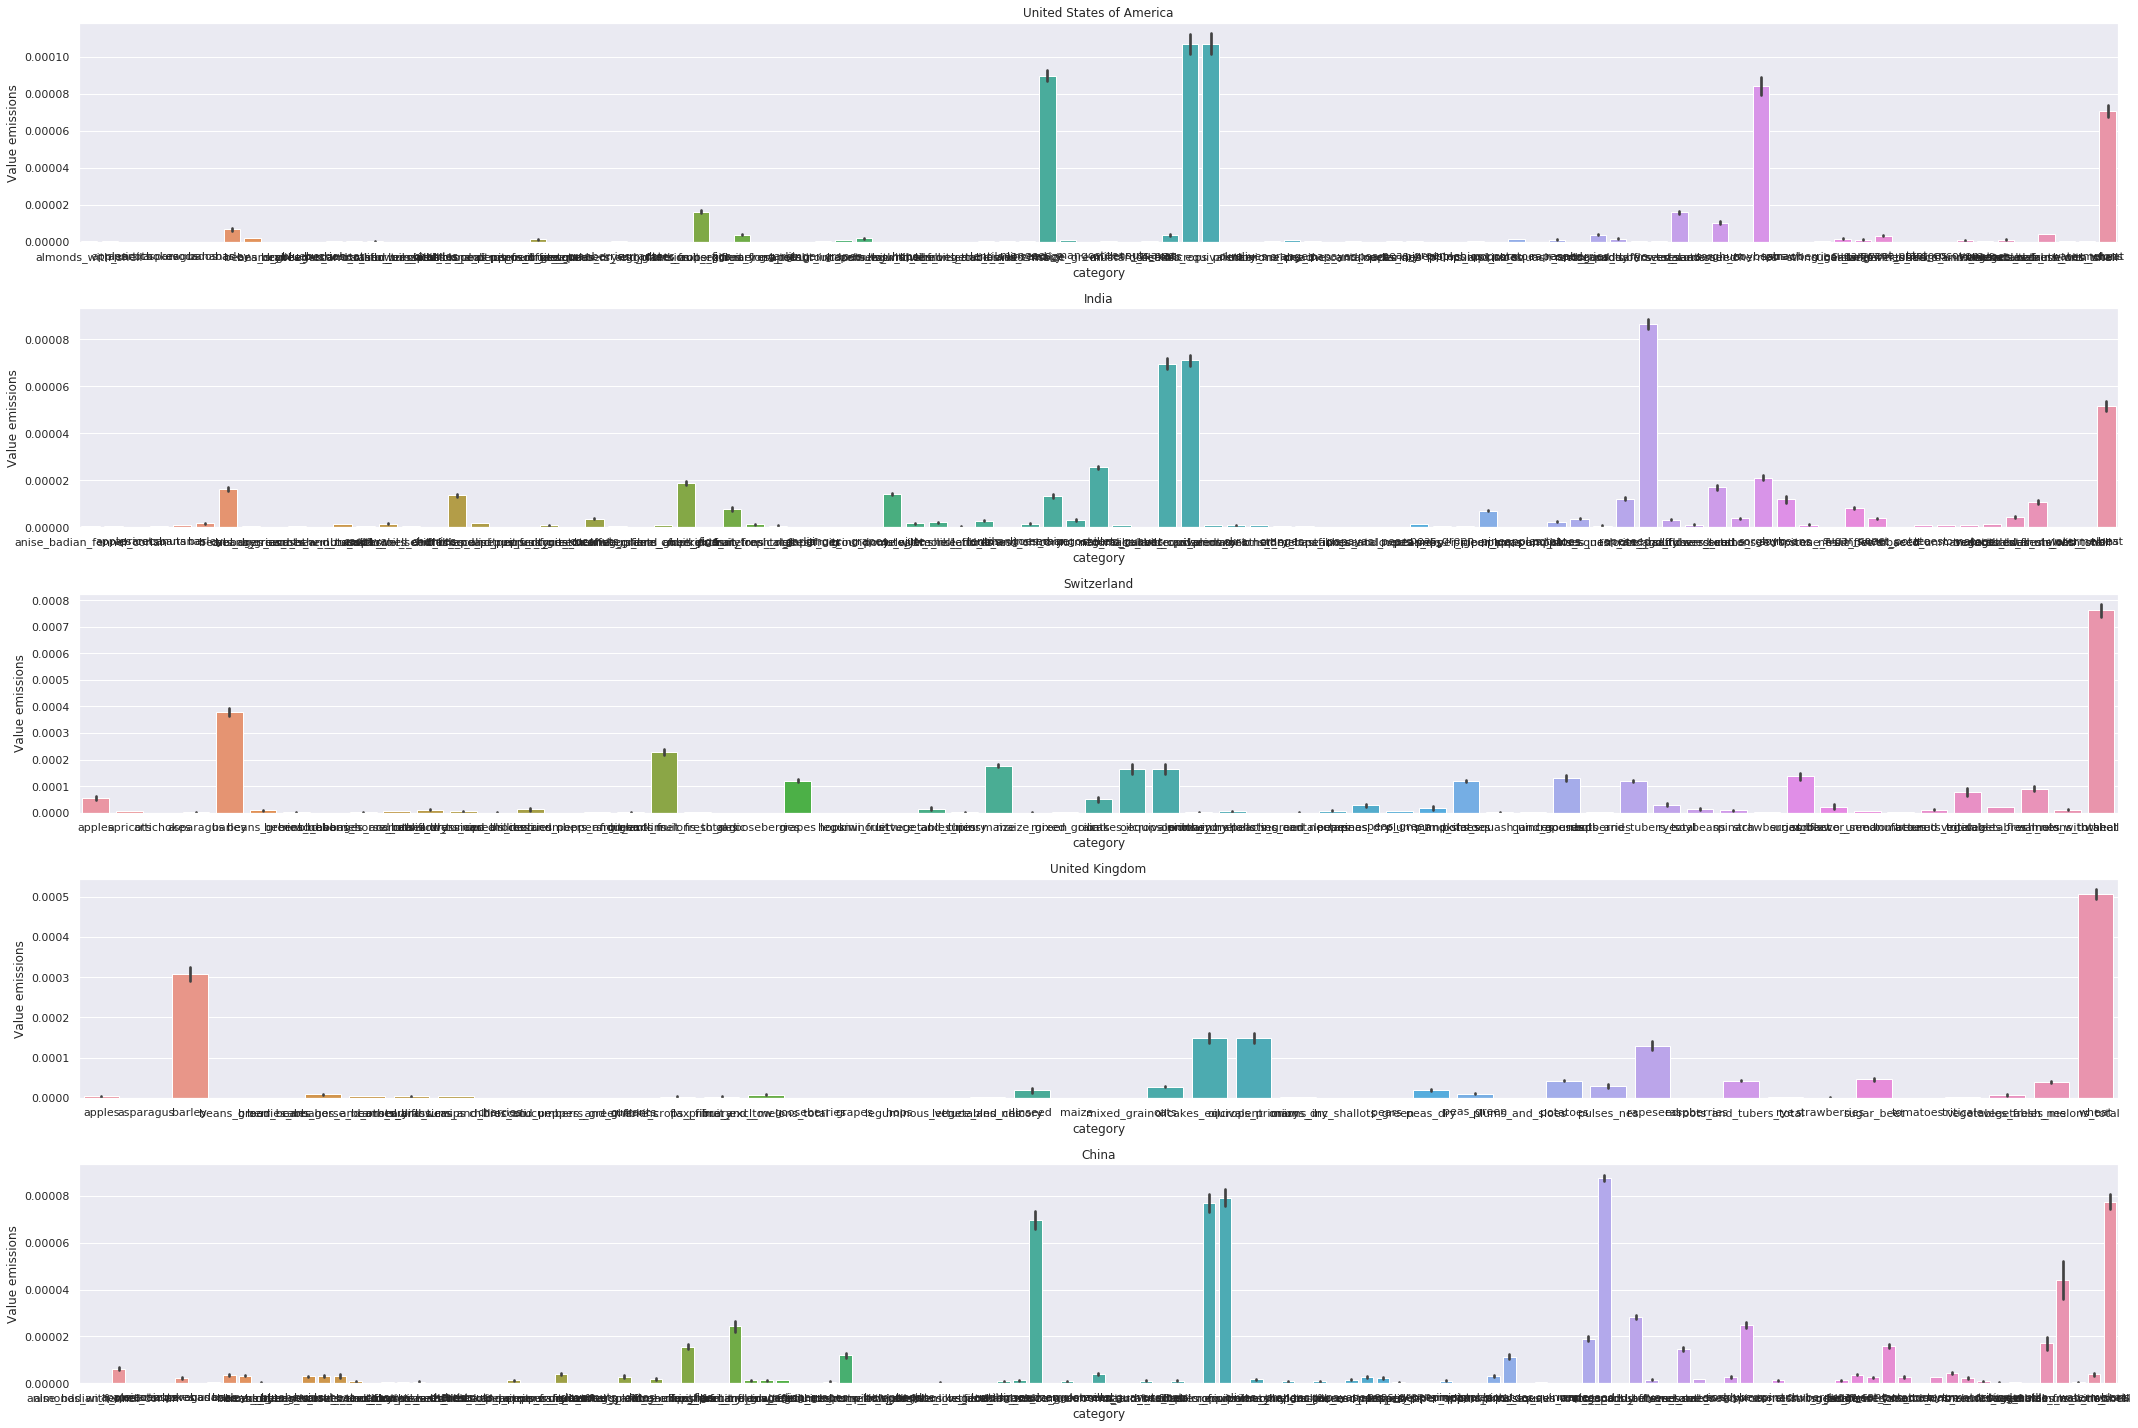

In [17]:
fg = plt.figure(figsize=(30,20))

i = 1

for c in listCountries:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(5,1,i)
    sns.barplot(x="category", y="Value emissions",\
                data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna(),\
                ax=axes)
    axes.set_title(c)
    i = i+1

fg.tight_layout()

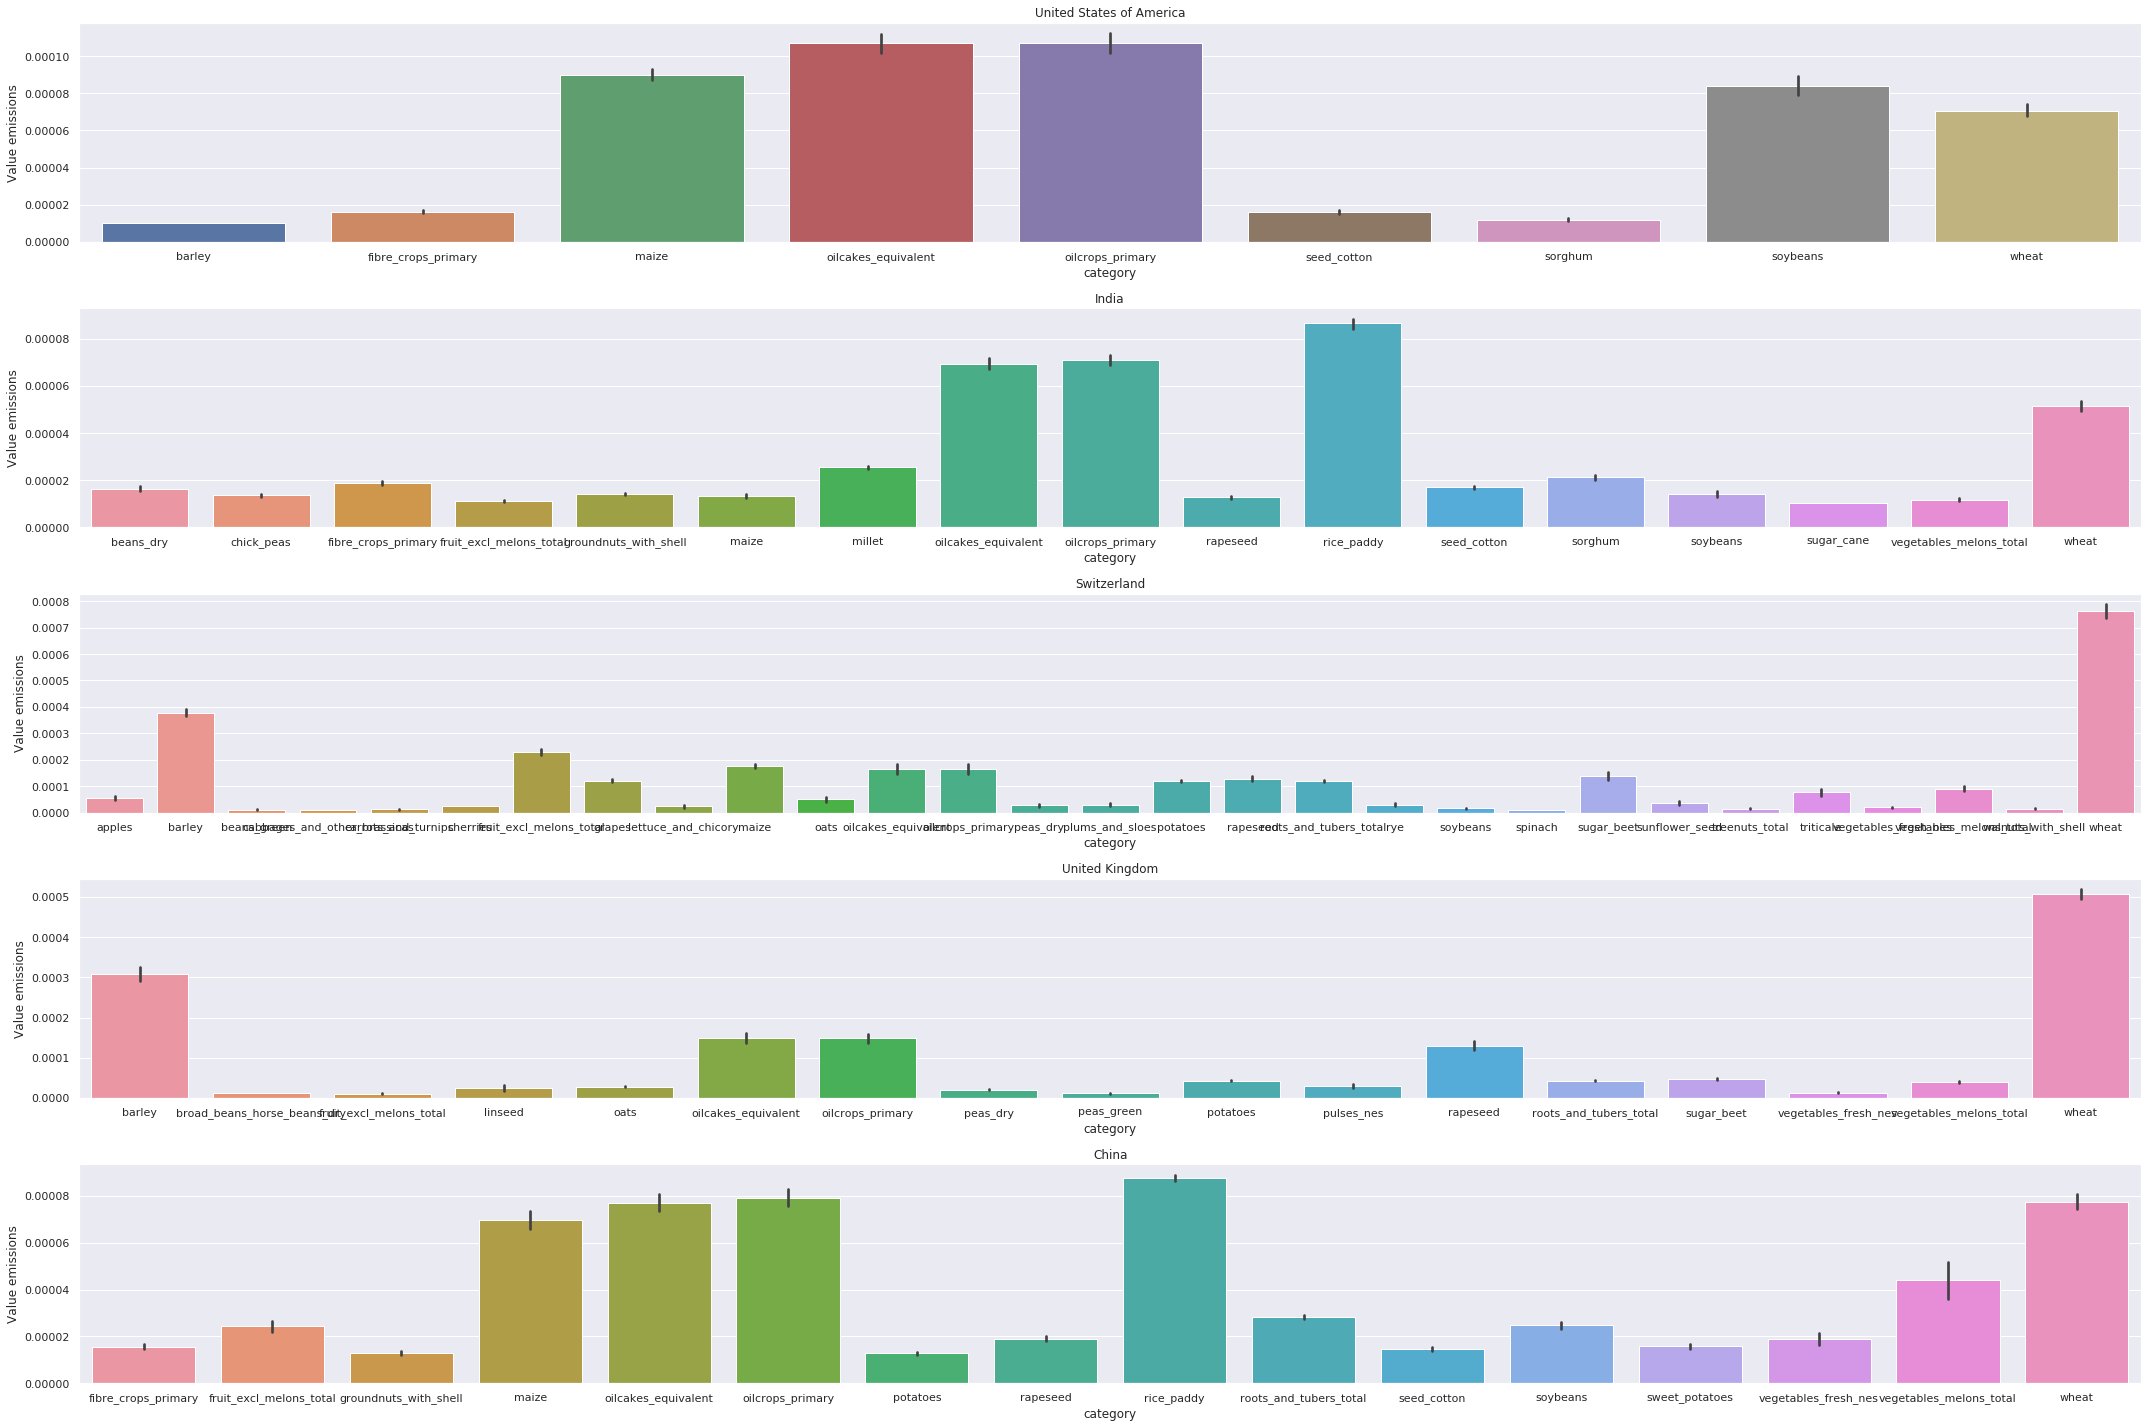

In [18]:
fg = plt.figure(figsize=(30,20))

i = 1

for c in listCountries:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    axes = fg.add_subplot(5,1,i)
    try:
        sns.barplot(x="category", y="Value emissions",\
                    data=cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).where(cropsEmissionsNormalized["Value emissions"] > 0.00001).dropna(),\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(c)
    i = i+1

fg.tight_layout()

In [19]:
population = pd.read_csv("./data/population.csv")

In [20]:
a = range(1960,2018)
years = []
for y in a:
    years.append(str(y))

population.drop(["Country Code", "Indicator Code", "2019"], axis=1)\
            .pivot(index="Country Name", columns="Indicator Name", values=years)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Indicator Name,"Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total",...,"Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total","Population, total"
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,8.996973e+06,9.169410e+06,9.351441e+06,9.543205e+06,9.744781e+06,9.956320e+06,1.017484e+07,1.039993e+07,1.063706e+07,1.089378e+07,...,2.772228e+07,2.839481e+07,2.918551e+07,3.011741e+07,3.116138e+07,3.226959e+07,3.337079e+07,3.441360e+07,3.538313e+07,3.629640e+07
Albania,1.608800e+06,1.659800e+06,1.711319e+06,1.762621e+06,1.814135e+06,1.864791e+06,1.914573e+06,1.965598e+06,2.022272e+06,2.081695e+06,...,2.947314e+06,2.927519e+06,2.913021e+06,2.905195e+06,2.900401e+06,2.895092e+06,2.889104e+06,2.880703e+06,2.876101e+06,2.873457e+06
Algeria,1.105786e+07,1.133634e+07,1.161983e+07,1.191280e+07,1.222168e+07,1.255088e+07,1.290263e+07,1.327503e+07,1.366358e+07,1.406172e+07,...,3.473061e+07,3.533388e+07,3.597746e+07,3.666144e+07,3.738389e+07,3.814013e+07,3.892369e+07,3.972802e+07,4.055140e+07,4.138920e+07
American Samoa,2.012300e+04,2.060200e+04,2.125300e+04,2.203400e+04,2.285400e+04,2.367200e+04,2.446200e+04,2.524800e+04,2.598900e+04,2.670300e+04,...,5.749200e+04,5.668300e+04,5.607900e+04,5.575900e+04,5.566700e+04,5.571300e+04,5.579100e+04,5.581200e+04,5.574100e+04,5.562000e+04
Andorra,1.341100e+04,1.437500e+04,1.537000e+04,1.641200e+04,1.746900e+04,1.854900e+04,1.964700e+04,2.075800e+04,2.189000e+04,2.305800e+04,...,8.386200e+04,8.446300e+04,8.444900e+04,8.374700e+04,8.242700e+04,8.077400e+04,7.921300e+04,7.801100e+04,7.729700e+04,7.700100e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.591977e+06,3.689099e+06,3.786161e+06,3.882986e+06,3.979998e+06,4.076708e+06,4.173398e+06,4.270092e+06,4.367088e+06,4.454805e+06
World,3.032020e+09,3.073078e+09,3.126066e+09,3.191186e+09,3.256700e+09,3.323624e+09,3.393699e+09,3.463147e+09,3.533537e+09,3.608236e+09,...,6.757887e+09,6.840592e+09,6.922947e+09,7.004011e+09,7.086994e+09,7.170962e+09,7.255654e+09,7.340548e+09,7.426103e+09,7.510990e+09


In [21]:
#cropsEmissionsNormalized

#countries = gap_reg[['China', 'United States of America', 'India', 'USSR', 'Brazil', 'France', 'Germany', 'Italy', 'Argentina', 'Indonesia']]

#from sklearn.linear_model import LinearRegression
#from matplotlib import pyplot as plt

def create_model_for_crop(crop):
    cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.category ==crop).dropna()
    lm = LinearRegression()
    
    cropData = cropData.groupby("Year").sum().reset_index()

    X = cropData[["Year"]]
    Y = cropData[["Value emissions"]]

    lm.fit(X,Y)
    
    return lm

models = []

for crop in cropsEmissionsNormalized.category.unique():
    models.append((crop,create_model_for_crop(crop)))
    
cropsModelsEmissionsPerUnitArea = pd.DataFrame(models, columns=("crop","model_emissions"))

#model.predict([2019,2020])
#pred=lm.predict(Y)
#pred_china = pred[0:11]
#pred_china  

In [22]:
for m in models:
    c = m[1].coef_[0][0]
    if c < 0:
        print(m[0] + " " + str(c))

asparagus -9.89252520928941e-06
bambara_beans -3.9878446196102757e-08
bananas -0.0002379822952063216
brazil_nuts_with_shell -1.308780201063082e-07
broad_beans_horse_beans_dry -2.9084726212980085e-06
carobs -6.113665893673277e-08
cashewapple -2.340905275210061e-07
cassava -6.545088511749192e-05
castor_oil_seed -6.394966623901331e-07
chick_peas -8.219424674555637e-07
cinnamon_canella -7.616783219045578e-06
cloves -1.5005305660468972e-06
coconuts -0.0002993750054567556
cow_peas_dry -1.985965837964121e-06
cucumbers_and_gherkins -0.00012196160827278035
fibre_crops_primary -1.168995406299576e-05
fonio -5.25856336492991e-07
fruit_excl_melons_total -0.0006029502231301062
fruit_fresh_nes -0.0008433738610123618
garlic -2.2922105649309896e-05
gooseberries -1.0960950332642074e-07
groundnuts_with_shell -4.451411283876806e-06
jute -4.749528235422914e-07
jute_jute_like_fibres -4.94459937713147e-07
kapok_fibre -3.464878032069755e-08
kapokseed_in_shell -3.464878032069755e-08
karite_nuts_sheanuts -9.190

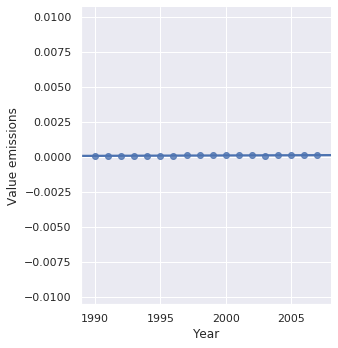

In [23]:
cropData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.category =="almonds_with_shell").dropna()
lm = LinearRegression()
    
cropData = cropData.groupby("Year").sum().reset_index()

sns.lmplot(x="Year", y="Value emissions", data=cropData)

In [24]:
def get_model_crop(crop, cropsData):
    cropsData = cropsData.where(cropsData.category ==crop).dropna()
    
    lm = LinearRegression()
    
    cropsData = cropsData.groupby("Year").sum().reset_index()
    
    X = cropsData[["Year"]]
    Y = cropsData[["Value area"]]
    
    try:
        lm.fit(X,Y)
    except ValueError as e:
        #print(str(e))
        return np.nan
    
    return lm

def get_model_crops_country(country):
    cropsData = cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area ==country).dropna()
    
    models = []

    for crop in cropsEmissionsNormalized.category.unique():
        models.append((crop,get_model_crop(crop, cropsData)))
    
    cropsModelsGrowth = pd.DataFrame(models, columns=("crop","model_growth"))
    
    return cropsModelsGrowth

class PredictorEmissionsCountry():
    def __init__(self, country, modelCrops, modelEmissionsByCrops):
        self.country = country
        self.modelCrops = modelCrops
        self.modelEmissionsByCrops = modelEmissionsByCrops
        
    def predict_emissions(self, startYear, endYear):
        years = []
        for i in range(startYear, endYear):
            years.append(i)
            
        def compute_production_area(row):
            return (row.model_growth.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions_per_unit_area(row):
            return (row.model_emissions.predict(pd.DataFrame(years)),)
        def compute_emissions(row):
            return (row.production_area*row.emissions_per_unit_area,)
        def flatten(arr):
            flatArr = []
            for i in arr:
                flatArr.append(i[0])
            return flatArr

        m = pd.merge(self.modelCrops, self.modelEmissionsByCrops, how="left", on=['crop']).dropna()
        m = m.join(m.apply(compute_production_area, axis=1, result_type="expand")).rename(columns={0:"production_area"})
        
        m = m.join(m.apply(compute_emissions_per_unit_area, axis=1, result_type="expand")).rename(columns={0:"emissions_per_unit_area"})
        m = m.join(m.apply(compute_emissions, axis=1, result_type="expand")).rename(columns={0:"emissions"})
        m.emissions = m.emissions.apply(flatten)
        m = pd.DataFrame(m.emissions.tolist(), columns=years)

        m = m.sum(0)
        return pd.DataFrame(m,columns=["emissions"]).reset_index().rename(columns={"index":"year"})

def get_model_emissions_countries(listCountries):
    #get_model_crops_country(country)
    
    predictorsEmissions = []

    for country in cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area.isin(listCountries)).dropna().Area.unique():
        predictorsEmissions.append(PredictorEmissionsCountry(country,\
                                                            get_model_crops_country(country),\
                                                            cropsModelsEmissionsPerUnitArea))
        print("Predictor for " + country + " done.")
    
    return predictorsEmissions

Predictor for China done.
Predictor for United States of America done.
Predictor for India done.
Predictor for Switzerland done.
Predictor for United Kingdom done.


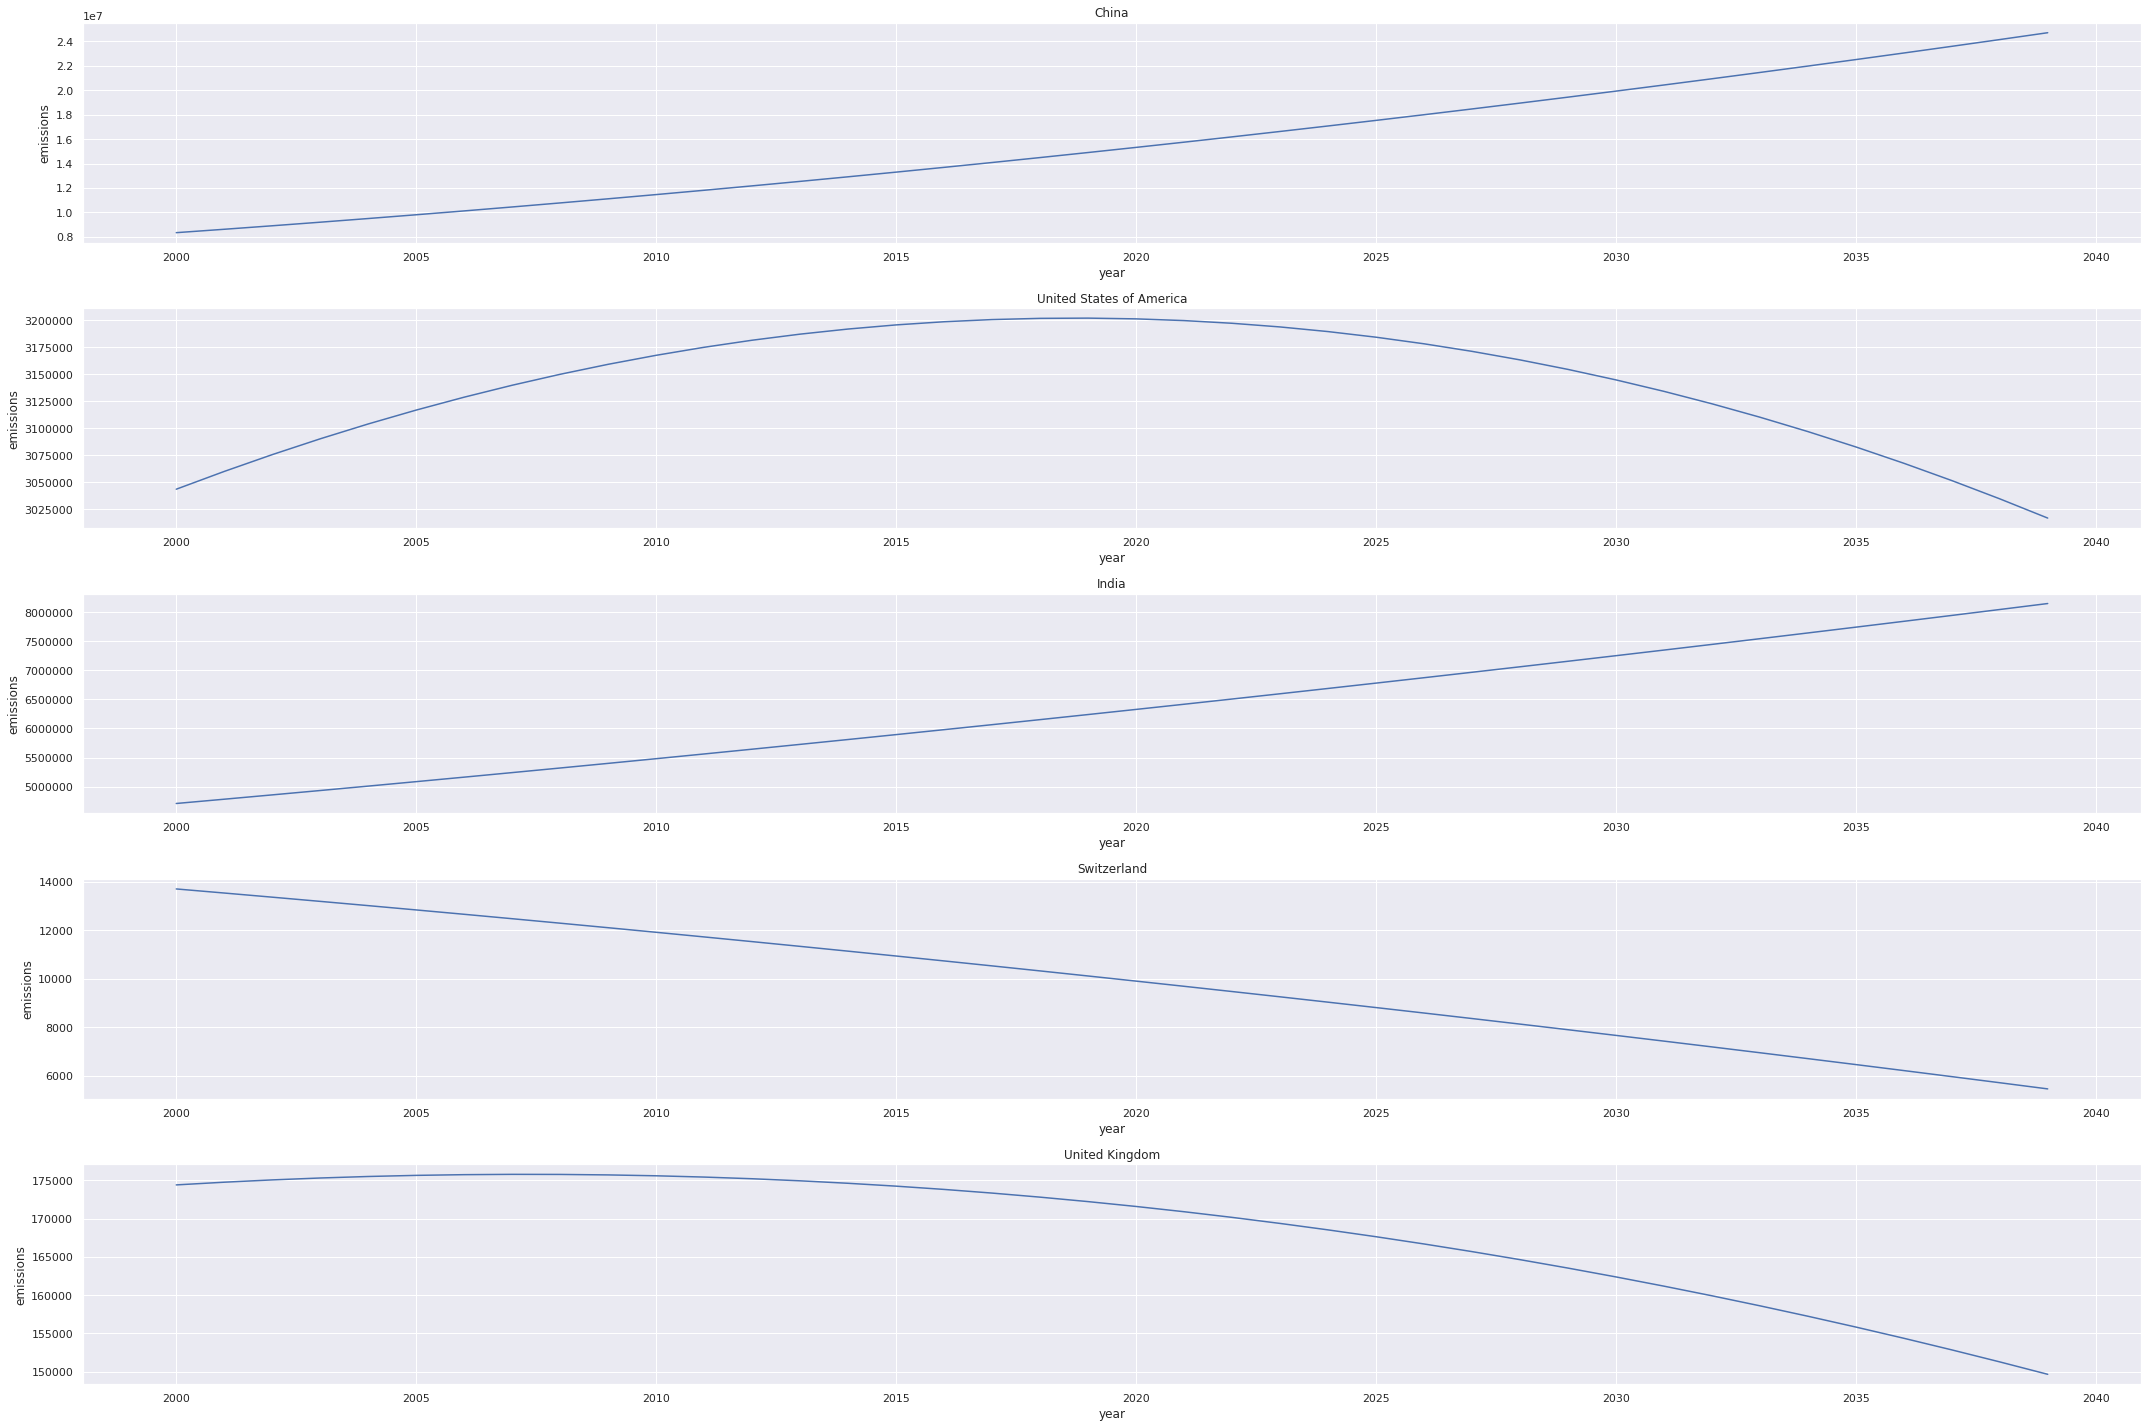

In [25]:
models = get_model_emissions_countries(listCountries)

fg = plt.figure(figsize=(30,20))

i = 1

for mc in models:
    #print(cropsEmissionsNormalized.where(cropsEmissionsNormalized.Area == c).dropna())
    emissions = mc.predict_emissions(2000,2040)
    axes = fg.add_subplot(5,1,i)
    try:
        sns.lineplot(x="year", y="emissions",data=emissions,\
                    ax=axes)
    except ValueError as e:
        print(str(e))
    axes.set_title(mc.country)
    i = i+1

fg.tight_layout()


In [26]:
pd.DataFrame(models[3].predict_emissions(2000,2040),columns=["emissions"]).reset_index().rename(columns={"index":"year"})

,year,emissions
0,0,13698.952221
1,1,13530.214562
2,2,13359.222329
3,3,13185.975522
4,4,13010.474140
5,5,12832.718184
6,6,12652.707653
7,7,12470.442548
8,8,12285.922869
9,9,12099.148615


In [27]:
def compute_production_area(row):
    years = []
    for i in range(1999, 2019):
        years.append(i)
    return (row.model_growth.predict(pd.DataFrame(years)),)

m = pd.merge(models[4].modelCrops, models[4].modelEmissionsByCrops, how="left", on=['crop']).dropna()
m = m.join(m.apply(compute_production_area, axis=1, result_type="expand")).rename(columns={0:"production_area"})
m.head(5)

,crop,model_growth,model_emissions,production_area
3,apples,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[14309.970416236669], [13677.800137598999], [..."
7,asparagus,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[886.6140350877249], [917.8421052631602], [94..."
11,barley,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[1153877.846577227], [1126655.7619539052], [1..."
13,beans_green,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[2950.07705538359], [2731.342277261778], [251..."
14,berries_nes,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[486.2463020295838], [486.1833505331957], [48..."


In [28]:
def compute_emissions_per_unit_area(row):
    years = []
    for i in range(1999, 2019):
        years.append(i)
    return (row.model_emissions.predict(pd.DataFrame(years)),)

#m = pd.merge(models[4].modelCrops, models[4].modelEmissionsByCrops, how="left", on=['crop']).dropna()
m = m.join(m.apply(compute_emissions_per_unit_area, axis=1, result_type="expand")).rename(columns={0:"emissions_per_unit_area"})
m.head(5)

,crop,model_growth,model_emissions,production_area,emissions_per_unit_area
3,apples,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[14309.970416236669], [13677.800137598999], [...","[[0.0014221300088189566], [0.00142640794265074..."
7,asparagus,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[886.6140350877249], [917.8421052631602], [94...","[[0.00019802043415723114], [0.0001881279089479..."
11,barley,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[1153877.846577227], [1126655.7619539052], [1...","[[0.019435299066545675], [0.019609002301507084..."
13,beans_green,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[2950.07705538359], [2731.342277261778], [251...","[[0.00048054239391957104], [0.0004985983083797..."
14,berries_nes,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[486.2463020295838], [486.1833505331957], [48...","[[4.016838253500447e-05], [4.105371608864334e-..."


In [29]:
def compute_emissions(row):
    return (row.production_area*row.emissions_per_unit_area,)

#m = pd.merge(models[4].modelCrops, models[4].modelEmissionsByCrops, how="left", on=['crop']).dropna()
m = m.join(m.apply(compute_emissions, axis=1, result_type="expand")).rename(columns={0:"emissions"})
m.head(5)

,crop,model_growth,model_emissions,production_area,emissions_per_unit_area,emissions
3,apples,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[14309.970416236669], [13677.800137598999], [...","[[0.0014221300088189566], [0.00142640794265074...","[[20.350638354241664], [19.510122754260664], [..."
7,asparagus,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[886.6140350877249], [917.8421052631602], [94...","[[0.00019802043415723114], [0.0001881279089479...","[[0.17556769615796586], [0.17267171600753425],..."
11,barley,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[1153877.846577227], [1126655.7619539052], [1...","[[0.019435299066545675], [0.019609002301507084...","[[22425.961034490116], [22092.595429160345], [..."
13,beans_green,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[2950.07705538359], [2731.342277261778], [251...","[[0.00048054239391957104], [0.0004985983083797...","[[1.4176370904412294], [1.3618426390487168], [..."
14,berries_nes,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","[[486.2463020295838], [486.1833505331957], [48...","[[4.016838253500447e-05], [4.105371608864334e-...","[[0.019531727466155644], [0.019959633239815183..."


In [30]:
def flatten(arr):
    flatArr = []
    for i in arr:
        flatArr.append(i[0])
    return flatArr

m.emissions = m.emissions.apply(flatten)

years = []
for i in range(1999, 2019):
    years.append(i)
m = pd.DataFrame(m.emissions.tolist(), columns=years)

m.sum(0)

1999    173981.694620
2000    174386.239684
2001    174738.859088
2002    175039.552833
2003    175288.320919
2004    175485.163345
2005    175630.080112
2006    175723.071220
2007    175764.136669
2008    175753.276459
2009    175690.490589
2010    175575.779060
2011    175409.141872
2012    175190.579025
2013    174920.090518
2014    174597.676352
2015    174223.336527
2016    173797.071042
2017    173318.879899
2018    172788.763096
dtype: float64